<a href="https://colab.research.google.com/github/ayushi-2104/Streamlit/blob/main/docs/tutorials/python/Predict%20engagement%20and%20emotions%20on%20video.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Predict engagement and emotions on video with Python interface of EmotiEffLib

The first GPU device should be used for cuda

In [28]:
%env CUDA_VISIBLE_DEVICES=0

env: CUDA_VISIBLE_DEVICES=0


Function to download test data downloader:

In [29]:
import os
import urllib.request

def get_test_data_downloader(test_dir):
    input_file = os.path.join(test_dir, "download_test_data.sh")
    if os.path.isfile(input_file):
        return input_file
    url = "https://github.com/sb-ai-lab/EmotiEffLib/blob/main/tests/download_test_data.sh?raw=true"
    print("Downloading download_test_data.sh from", url)
    input_file = "download_test_data.sh"
    if os.path.isfile(input_file):
        return input_file
    urllib.request.urlretrieve(url, input_file)
    return input_file

Check if it runs under colab and install dependencies:

In [30]:
try:
    import google.colab
    IN_COLAB = True
    urllib.request.urlretrieve("https://github.com/sb-ai-lab/EmotiEffLib/blob/main/docs/tutorials/python/requirements.txt?raw=true", "requirements.txt")
    !pip install -r requirements.txt
except:
    IN_COLAB = False

Download test data:

In [50]:
# Remove or comment out these lines:
# data_downloader = get_test_data_downloader("../../../tests")
# !rm -rf data data.tar.gz
# !sh {data_downloader}
# !tar -xzf data.tar.gz

# Add this instead:
from google.colab import files
print("Please upload your video file:")
uploaded = files.upload()
input_file = next(iter(uploaded))

Please upload your video file:


Saving vedio.mp4 to vedio (1).mp4


Function for faces recognition:

In [51]:
from typing import List
import numpy as np

def recognize_faces(frame: np.ndarray, device: str) -> List[np.array]:
    """
    Detects faces in the given image and returns the facial images cropped from the original.

    This function reads an image from the specified path, detects faces using the MTCNN
    face detection model, and returns a list of cropped face images.

    Args:
        frame (numpy.ndarray): The image frame in which faces need to be detected.
        device (str): The device to run the MTCNN face detection model on, e.g., 'cpu' or 'cuda'.

    Returns:
        list: A list of numpy arrays, representing a cropped face image from the original image.

    Example:
        faces = recognize_faces('image.jpg', 'cuda')
        # faces contains the cropped face images detected in 'image.jpg'.
    """

    def detect_face(frame: np.ndarray):
        mtcnn = MTCNN(keep_all=False, post_process=False, min_face_size=40, device=device)
        bounding_boxes, probs = mtcnn.detect(frame, landmarks=False)
        if probs[0] is None:
            return []
        bounding_boxes = bounding_boxes[probs > 0.9]
        return bounding_boxes

    bounding_boxes = detect_face(frame)
    facial_images = []
    for bbox in bounding_boxes:
        box = bbox.astype(int)
        x1, y1, x2, y2 = box[0:4]
        facial_images.append(frame[y1:y2, x1:x2, :])
    return facial_images

## EmotiEffLib with ONNX

Install EmotiEffLib with ONNX support:

In [52]:
!pip install emotiefflib[engagement]

Import libraries:

In [53]:
import os
from typing import List

import cv2
import matplotlib.pyplot as plt
import numpy as np
from facenet_pytorch import MTCNN
from emotiefflib.facial_analysis import EmotiEffLibRecognizer, get_model_list

Path to the directory with test data, select device and model:

In [54]:
test_dir = "data"
device = "cpu"
model_name = get_model_list()[0]

### Read video and recognize engagement:

For engagement recognition, we need to collect a sequence of video frames before predicting engagement class. To avoid extracting visual features for the same frames in different sliding windows, it is better to read the whole video before recognizing engagement or extract visual features for each frame before passing them to classifier.

Read the whole video:

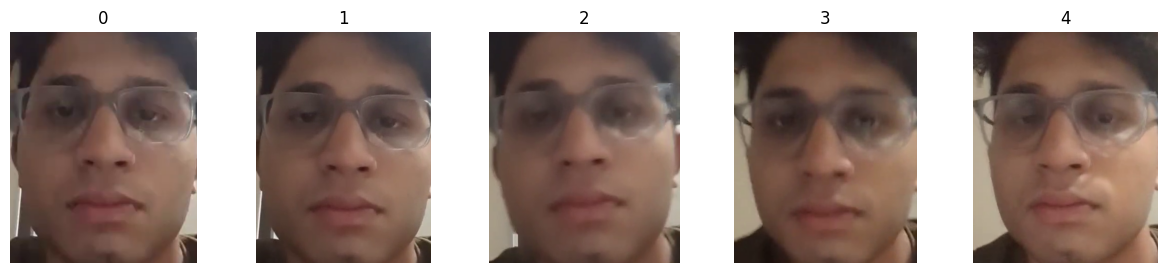

In [55]:
input_file = next(iter(uploaded))  # or the variable you stored it in

all_frames = []
# Create a row of 5 subplots
fig, axes = plt.subplots(1, 5, figsize=(15, 3))
i = 0

# Read the whole video
cap = cv2.VideoCapture(input_file)
while cap.isOpened():
    success, image = cap.read()
    if not success:
        break

    image_rgb = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    facial_images = recognize_faces(image_rgb, device)
    if len(facial_images) == 0:
        continue
    all_frames += facial_images
    # Draw each 10th frame
    if i % 10 == 0 and i // 10 < 5:
        idx = i // 10
        axes[idx].imshow(facial_images[0])
        axes[idx].set_title(idx)
        axes[idx].axis('off')
    i += 1

cap.release()

Recognize engagement using `predict_engagement` method:

In [56]:
sliding_window_size = 128
fer = EmotiEffLibRecognizer(engine="onnx", model_name=model_name, device=device)
# We also can skip sliding_window_size parameter, because default value is also 128
_, scores = fer.predict_engagement(all_frames, sliding_window_size)
score = np.mean(scores, axis=0)
engagement_idx = np.argmax(score)

assert fer.idx_to_engagement_class[engagement_idx] == "Engaged"

error: OpenCV(4.11.0) /io/opencv/modules/imgproc/src/resize.cpp:4208: error: (-215:Assertion failed) !ssize.empty() in function 'resize'


### Recognize engagement and emotions on a sequence of frames by calling features extractor and classifier separately

In [57]:
features = fer.extract_features(all_frames)
_, emotion_scores = fer.classify_emotions(features, logits=True)
_, engagement_scores = fer.classify_engagement(features)
emotion_score = np.mean(emotion_scores, axis=0)
engagement_score = np.mean(engagement_scores, axis=0)
emotion_idx = np.argmax(emotion_score)
engagement_idx = np.argmax(engagement_score)

assert fer.idx_to_emotion_class[emotion_idx] == "Sadness"
assert fer.idx_to_engagement_class[engagement_idx] == "Engaged"

error: OpenCV(4.11.0) /io/opencv/modules/imgproc/src/resize.cpp:4208: error: (-215:Assertion failed) !ssize.empty() in function 'resize'


## EmotiEffLib with Torch

Install EmotiEffLib with Torch support:

In [58]:
!pip install emotiefflib[all]

Import libraries:

In [59]:
import os
from typing import List

import cv2
import torch
import matplotlib.pyplot as plt
import numpy as np
from facenet_pytorch import MTCNN
from emotiefflib.facial_analysis import EmotiEffLibRecognizer, get_model_list

Path to the directory with test data, select device and model:

In [60]:
test_dir = "data"
device = "cuda" if torch.cuda.is_available() else "cpu"
model_name = get_model_list()[0]

### Read video and recognize engagement:

For engagement recognition, we need to collect a sequence of video frames before predicting engagement class. To avoid extracting visual features for the same frames in different sliding windows, it is better to read the whole video before recognizing engagement or extract visual features for each frame before passing them to classifier.

Read the whole video:

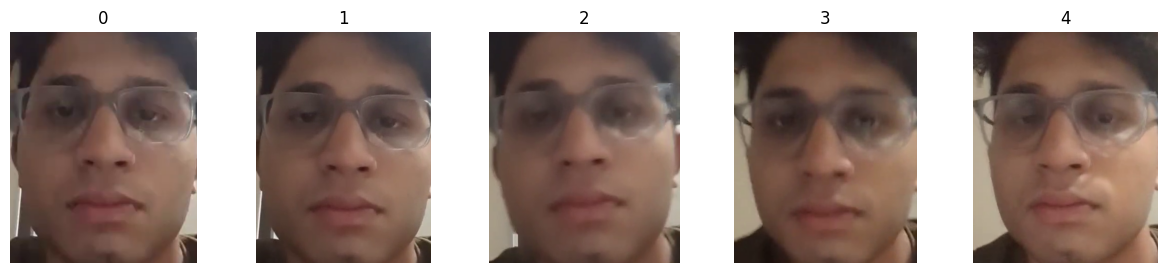

In [61]:
input_file = next(iter(uploaded))  # or the variable you stored it in

all_frames = []
# Create a row of 5 subplots
fig, axes = plt.subplots(1, 5, figsize=(15, 3))
i = 0

# Read the whole video
cap = cv2.VideoCapture(input_file)
while cap.isOpened():
    success, image = cap.read()
    if not success:
        break

    image_rgb = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    facial_images = recognize_faces(image_rgb, device)
    if len(facial_images) == 0:
        continue
    all_frames += facial_images
    # Draw each 10th frame
    if i % 10 == 0 and i // 10 < 5:
        idx = i // 10
        axes[idx].imshow(facial_images[0])
        axes[idx].set_title(idx)
        axes[idx].axis('off')
    i += 1

cap.release()

Recognize engagement using `predict_engagement` method:

In [62]:
sliding_window_size = 128
fer = EmotiEffLibRecognizer(engine="onnx", model_name=model_name, device=device)
# We also can skip sliding_window_size parameter, because default value is also 128
_, scores = fer.predict_engagement(all_frames, sliding_window_size)
score = np.mean(scores, axis=0)
engagement_idx = np.argmax(score)

assert fer.idx_to_engagement_class[engagement_idx] == "Engaged"

error: OpenCV(4.11.0) /io/opencv/modules/imgproc/src/resize.cpp:4208: error: (-215:Assertion failed) !ssize.empty() in function 'resize'


### Recognize engagement and emotions on a sequence of frames by calling features extractor and classifier separately

In [63]:
features = fer.extract_features(all_frames)
_, emotion_scores = fer.classify_emotions(features, logits=True)
_, engagement_scores = fer.classify_engagement(features)
emotion_score = np.mean(emotion_scores, axis=0)
engagement_score = np.mean(engagement_scores, axis=0)
emotion_idx = np.argmax(emotion_score)
engagement_idx = np.argmax(engagement_score)

assert fer.idx_to_emotion_class[emotion_idx] == "Sadness"
assert fer.idx_to_engagement_class[engagement_idx] == "Engaged"

error: OpenCV(4.11.0) /io/opencv/modules/imgproc/src/resize.cpp:4208: error: (-215:Assertion failed) !ssize.empty() in function 'resize'
